## Binary decision tree

***Gini Impurity Index***:
Suppose we're looking at the jth node,  
  
\\(I_{Gini}(j) = \Sigma_i p(i|j)(1-p(i|j)) \\), where i is the index for each class in node j.  
  
Given a sample, the Gini impurity measures the probability of a misclassification if a label is randomly chosen using the probability distribution of the branch. ***It's a \\(p(i|j)\\) chance to pick class i, multiplied by 1-p(i|j), which is the chance of misclassing this observation of class i***. Summation is then used to add up the total chance of misclassification as a measurement of impurity, since if it's pure (1 class), there would be no chance of misclassifying; if there were more classes, and uniform distribution, the impurity will be the worst.   

    

Cross entropy index:  
  
\\(I_{cross-entropy}(j) = -\Sigma_i p(i|j)log p(i|j) \\)  
  
The ***cross-entropy*** allows you to ***select the split that minimizes the uncertainty about the classification***, while the ***Gini impurity minimizes the probability of misclassification***.


Misclassification impurity index:
    
\\(I_{Missclassification}(j) = 1 - max(p(i|j)) \\)  
  
In terms of quality performance, this index is not the best choice because it's not particularly sensitive to different probability distributions (which can easily drive the selection to a subdivision using Gini or cross-entropy indexes). (It doesn't reflect much of the information involved in the impurity, not an effective index).

Importance of a feature \\(x_i\\):  
  
\\(Importance(x_i) = \Sigma_k \frac{N_k}{N}\Delta I_{x_i}\\)  
  
The importance is a weighted sum of all impurity reductions computed considering only the nodes where the feature is used to split them (weighted sum of all the impurity reductions attributed to \\(x_i\\)). If the Gini impurity index is adopted, this measure is also called ***Gini importance***.

In [36]:
import numpy as np

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score


# For reproducibility
np.random.seed(100)

nb_samples = 500

# Set a folder to store the graph in
graph_folder = '/kaggle/working/'

In [37]:
# Create dataset
X, Y = make_classification(n_samples=nb_samples, n_features=3, n_informative=3, n_redundant=0, n_classes=3,
                            n_clusters_per_class=1)

# Create a Decision tree classifier
dt = DecisionTreeClassifier()
dt_scores = cross_val_score(dt, X, Y, scoring='accuracy', cv=10)
print('Decision tree score: %.3f' % dt_scores.mean())

Decision tree score: 0.844


In [38]:
# Save in Graphviz format
dt.fit(X, Y)

with open(graph_folder + 'dt.dot', 'w') as df:
    df = export_graphviz(dt, out_file=df,
                            feature_names=['A', 'B', 'C'],
                            class_names=['C1', 'C2', 'C3'])

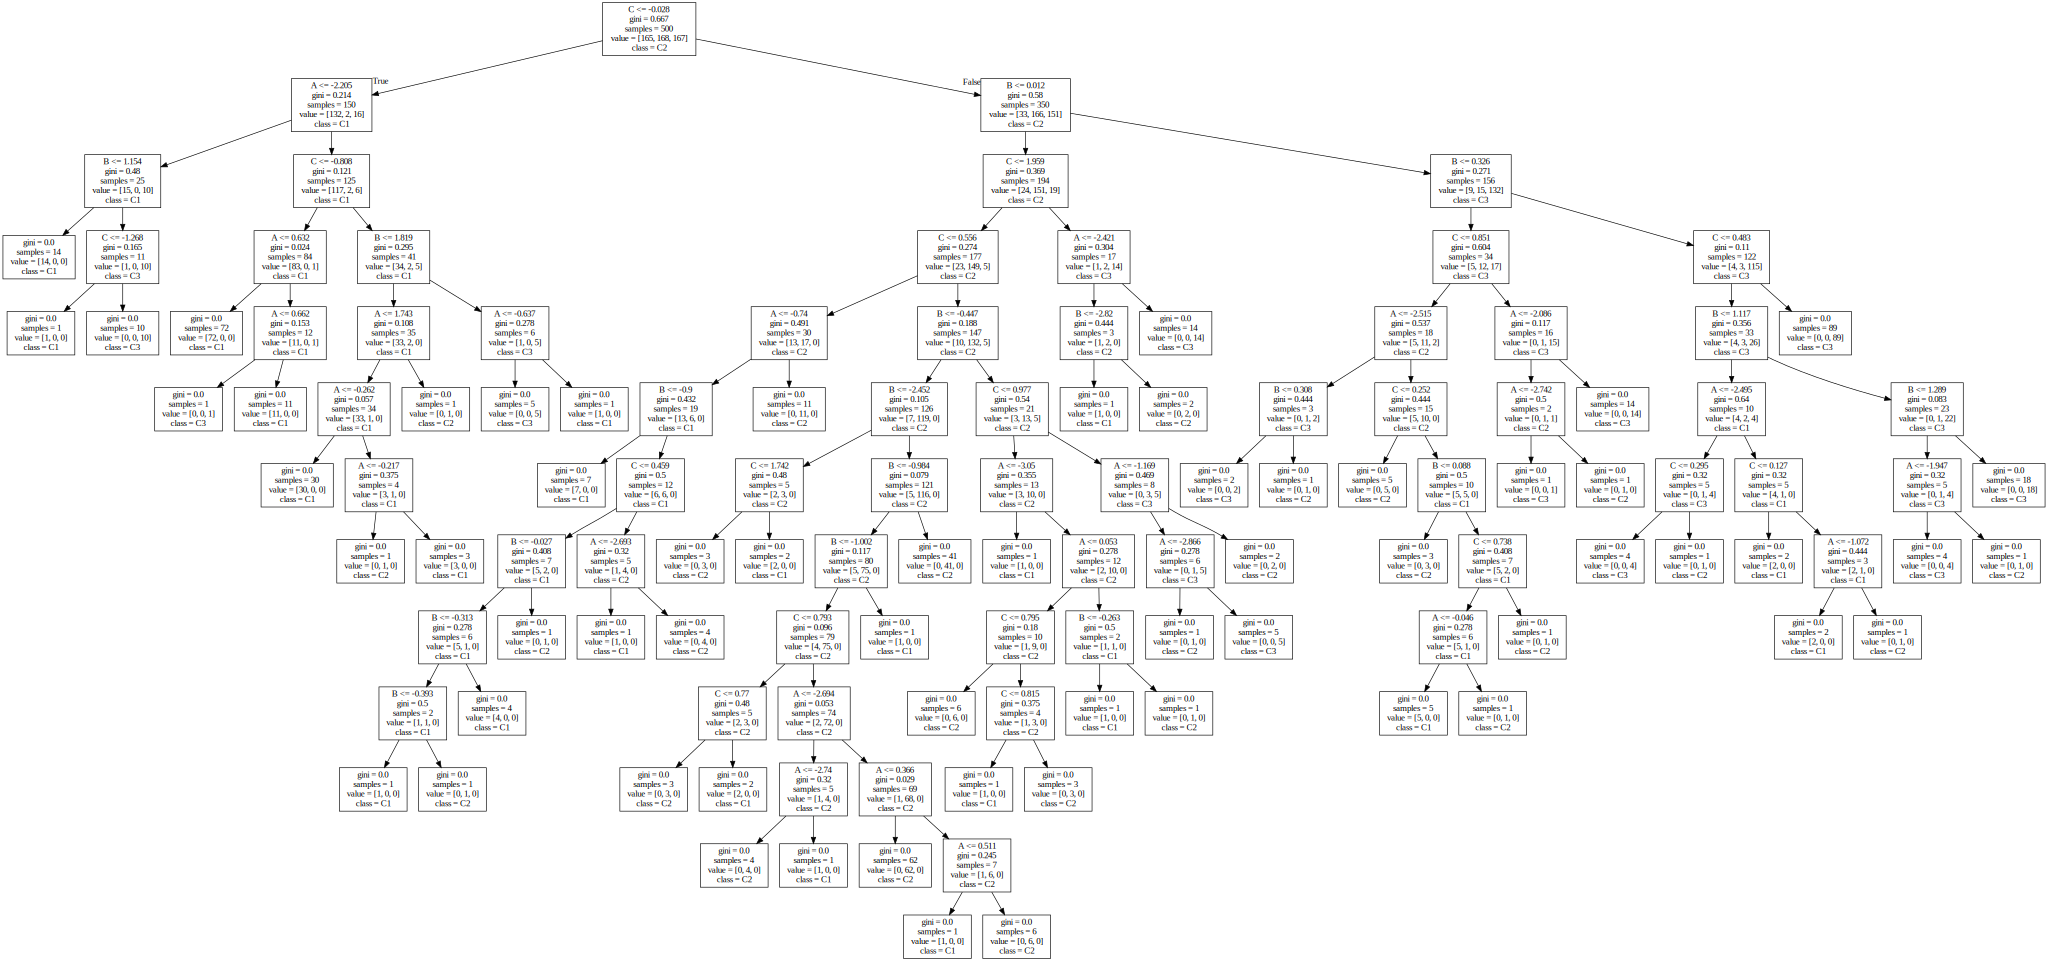

In [39]:
from graphviz import Source
Source.from_file(graph_folder + '/dt.dot')
# check out https://graphviz.readthedocs.io/en/stable/manual.html for more.

Unfortunately, ***even if the process is quite simple, the dataset structure can lead to very complex trees, while other methods can immediately find out the most appropriate class***. Of course, not all features have the same importance. If we consider ***the root of the tree and the first nodes***, we find features that separate a lot of samples; therefore, ***their importance must be higher than that of all terminal nodes, where the residual number of samples is minimum***. In scikit-learn, it's possible to assess the Gini importance of each feature after training a model:

In [40]:
dt.feature_importances_

array([0.13535731, 0.40566005, 0.45898264])

### max_features

In terms of efficiency, a tree can also be pruned using the max_depth parameter; however, it's not always so simple to understand which value is the best (***grid search can help in this task***).  
  
On the other hand, it's easier to decide what the maximum number of features to consider at each split should be. The parameter ***max_features*** can be used for this purpose:
* 'None', all the features will be used (default)
* a number
* 'auto' or 'sqrt', the square root of the number of features
* 'log2', the logarithm (base 2) will be used


In general, when ***the number of total features is not too high, the default value is the best choice***, although it's useful to introduce ***a small compression (via sqrt or log2) when too many features can interfere among themselves***, reducing the efficiency.

### min_samples_split

specifies the minimum number of samples to consider for a split.

In [41]:
cross_val_score(DecisionTreeClassifier(), X, Y, scoring='accuracy', cv=10).mean()

0.8480000000000001

In [46]:
cross_val_score(DecisionTreeClassifier(max_features='log2'), X, Y, scoring='accuracy', cv=10).mean()

0.818

In [50]:
cross_val_score(DecisionTreeClassifier(min_samples_split=400), X, Y, scoring='accuracy', cv=10).mean()

0.596

The larger the min_samples_split, the worse the performance as a high samples number requirement makes it less probable to construct as good a split. Likewise, the fewer the max_features considered, the faster the result, but the worse the seperation. 

## Grid search on MNIST data set

In [55]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import multiprocessing

In [58]:
digits = load_digits()

param_grid = [
    {
        'criterion': ['gini', 'entropy'],
        'max_features': ['auto', 'log2', None],
        'min_samples_split': [2, 10, 25, 100, 200],
        'max_depth': [5, 10, 15, None]
    }
]

gs= GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=param_grid, 
                 scoring='accuracy', cv=10, n_jobs= multiprocessing.cpu_count())

gs.fit(digits.data, digits.target)

print(gs.best_estimator_,gs.best_estimator_.get_params())

print('Decision tree score: %.3f' % gs.best_score_)


DecisionTreeClassifier() {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}
Decision tree score: 0.831


In this case, the element that impacted accuracy the most is the minimum number of samples to consider for a split. This is reasonable, considering the structure of this dataset and the need to have many branches to capture even small changes.